In [1]:
import torch
import requests 
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from io import BytesIO
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from torchvision import transforms as tfms
from diffusers import (
    StableDiffusionPipeline,
    DDIMScheduler
)



def load_image(url, size=None):
    response = requests.get(url, timeout=.2)
    img = Image.open(BytesIO(response.content)).convert("RGB")
    if size is not None:
        img = img.resize(size)
    return img
device = "cuda" if torch.cuda.is_available() else "cpu"

/media/mix060514/Data/pj/diffusers-test/venv/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/media/mix060514/Data/pj/diffusers-test/venv/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
# pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5").to(device)
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", revision='fp16',torch_type=torch.float16).to(device)
pipe.enable_attention_slicing()
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
prompt = "Beautiful DSLR Photograph of a penguin on the beach, golden hour"
negative_prompt = "blurry, ugly, stock photo"


/media/mix060514/Data/pj/diffusers-test/venv/lib/python3.10/site-packages/diffusers/pipelines/pipeline_utils.py:270: FutureWarning: You are loading the variant fp16 from runwayml/stable-diffusion-v1-5 via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(
text_encoder/model.safetensors not found
Keyword arguments {'torch_type': torch.float16} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/media/mix060514/Data/pj/diffusers-test/venv/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [ ]:
im = pipe(prompt, negative_prompt=negative_prompt, height=256, width=256,)
im


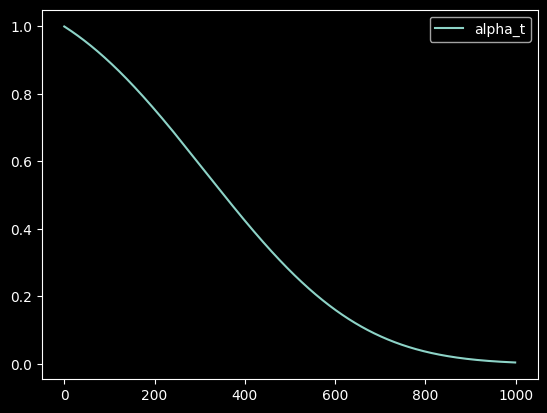

In [3]:
timesteps = pipe.scheduler.timesteps.cpu()
alphas = pipe.scheduler.alphas_cumprod[timesteps]
plt.plot(timesteps, alphas, label='alpha_t')
plt.legend()



In [4]:
@torch.no_grad()
def sample(prompt, start_step=0, start_latents=None, guidance_scale=3.5, num_inference_steps=30, num_images_per_prompt=1, do_classifier_free_guidance=True, negative_prompt='', device=device):
    text_embeddings = pipe.encode_prompt(prompt, device, num_images_per_prompt, do_classifier_free_guidance, negative_prompt)
    pipe.scheduler.set_timesteps(num_images_per_prompt, device=device)
    if start_latents is None:
        start_latents = torch.randn(1, 4, 64, 64, device=device)
        start_latents *= pipe.scheduler.init_noise_sigma 
    latents = start_latents.clone()
    for i in tqdm(range(start_step, num_images_per_prompt)):
        t = pipe.scheduler.timesteps[i]
        latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
        latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample 
        if do_classifier_free_guidance:
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
            prev_t = max(1, t.item() - (1000//num_inference_steps))
            alpha_t = pipe.scheduler.alphas_cumprod[t.item()]
            alpha_t_prev = pipe.scheduler.alphas_cumprod[prev_t]
            predicted_x0 = (latents - (1-alpha_t).sqrt() * noise_pred) / alpha_t.sqrt()
            direction_pointing_to_xt = (1-alpha_t_prev).sqrt() * noise_pred
            latents = alpha_t_prev*predicted_x0 + direction_pointing_to_xt
    images = pipe.decode_latents(latents)
    images = pipe.numpy_to_pil(images)
    return images

sample('watercolor painting of a beach sunset', negative_prompt=negative_prompt, num_inference_steps=50)[0].resize((256, 256))

  0%|          | 0/1 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 256.00 MiB. GPU 0 has a total capacity of 5.80 GiB of which 251.19 MiB is free. Including non-PyTorch memory, this process has 5.50 GiB memory in use. Of the allocated memory 5.22 GiB is allocated by PyTorch, and 187.40 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)